Функции потерь и оптимизация

Прочитать про методы оптимизации для нейронных сетей https://habr.com/post/318970/
Реализовать самостоятельно логистическую регрессию.

Обучить ее
- методом градиентного спуска
- методом nesterov momentum
- методом rmsprop
В качестве dataset’а взять Iris, оставив 2 класса:
Iris Versicolor
Iris Virginica


In [1]:
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
# data.target[[10, 25, 50]]

list(iris.target_names)
#['setosa', 'versicolor', 'virginica']


['setosa', 'versicolor', 'virginica']

In [2]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)

df['class'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
# only 2 types, Iris Versicolor (1) and Iris Virginica (2)

df = df[df['class'] != 0]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = df['class'].values
X = df.drop('class', axis=1).values
model = LinearRegression()
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.20,random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

model.score(X_test, y_test)


0.6121351626426308

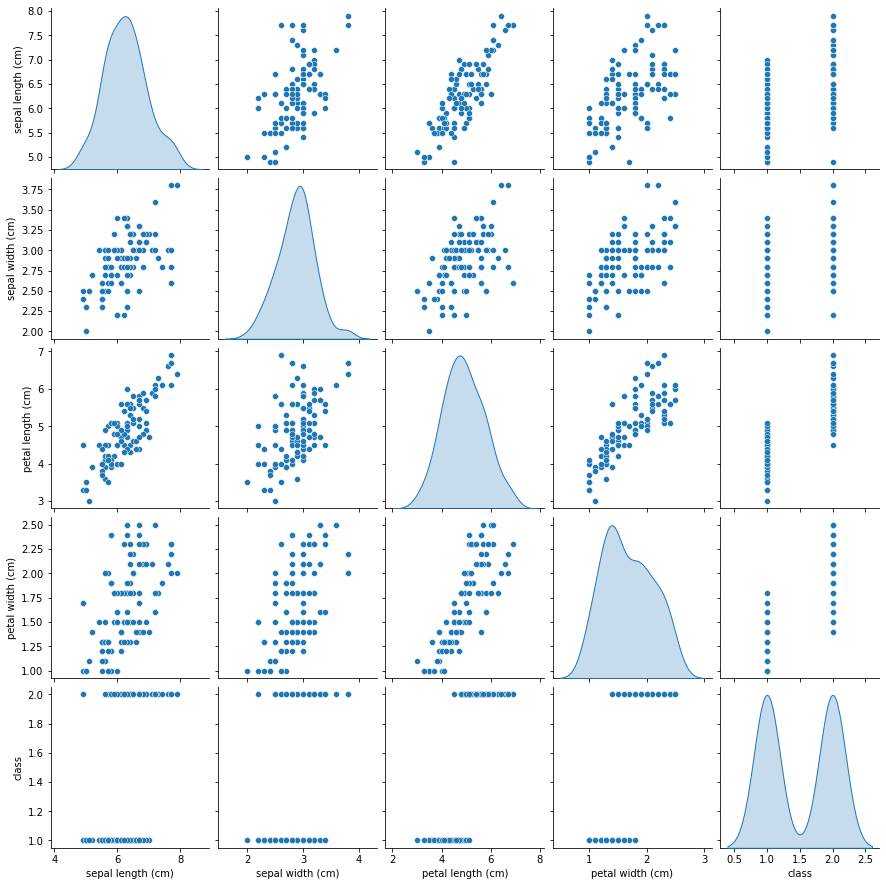

In [5]:
import seaborn as sns
sns.pairplot(df, diag_kind="kde")

C:\Users\asd\anaconda3\envs\scientificProject\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


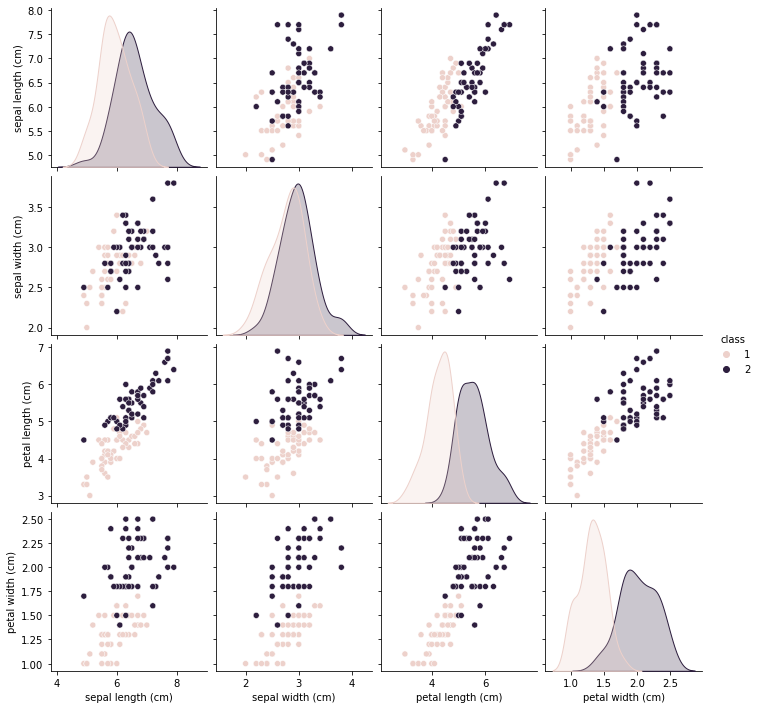

In [6]:
sns.pairplot(df, hue='class', size=2.5)


array([[<AxesSubplot:title={'center':'petal width (cm)'}>]], dtype=object)

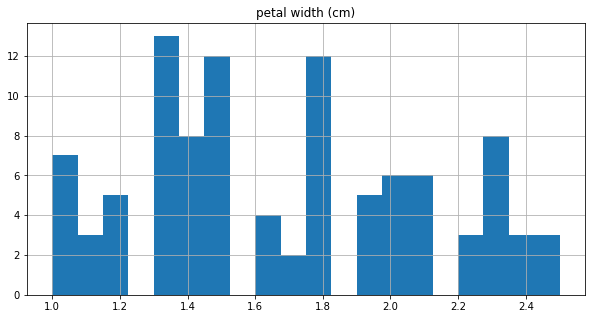

In [7]:
df.hist(column = 'petal width (cm)',bins=20, figsize=(10,5))

In [8]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

inp_df = df.drop(df.columns[[4]], axis=1)
out_df = df.drop(df.columns[[0,1,2,3]], axis=1)
#
scaler = StandardScaler()
inp_df = scaler.fit_transform(inp_df)
#
X_train, X_test, y_train, y_test = train_test_split(inp_df, out_df, test_size=0.2, random_state=42)

X_tr_arr = X_train
X_ts_arr = X_test
y_tr_arr = y_train.to_numpy()
y_ts_arr = y_test.to_numpy()
#
print('Input Shape', X_tr_arr.shape)
print('Output Shape', X_test.shape)

Input Shape (80, 4)
Output Shape (20, 4)


In [12]:

def weight_initialization(n_features, b=0):
    w = np.zeros((1, n_features))
    return w, b

def sigmoid_activation(result, gamma=None):
    return 1 / (1 + np.exp(-result))

def cost(features, target, shape):
    return (-1/shape)*(np.sum((target*np.log(features)) + ((1-target)*(np.log(1-features)))))

def simple(features, gamma=0.9, lr=0.25, target=None, shape=None):
    return np.sum(gamma*np.log(features) + lr)

def nesterov(features, gamma=0.9, lr=0.75, target=None, shape=None):
    return np.sum(gamma*np.log(features) + lr*np.log(features))

def rms_prop(features, gamma=0.9, lr=0.25, eps=0.00001, target=None, shape=None):
    eg = gamma + (1-gamma)*np.log(features)*np.log(features)
    return np.sum(lr/np.sqrt(eg + eps) * np.log(features))

def model_optimize(w, b, X, Y, opt=cost):
    m = X.shape[0]
    x_targets = X.T

    # activation
    result = np.dot(w, x_targets) + b
    final_result = sigmoid_activation(result)

    y_targets = Y.T
    cost_v = opt(final_result, target=y_targets, shape=m)

    # calculation
    dw = (1/m)*(np.dot(x_targets, (final_result-y_targets).T))
    db = (1/m)*(np.sum(final_result-y_targets))

    grads = {"dw": dw, "db": db}

    return grads, cost_v

def model_predict(w, b, X, Y, learning_rate, no_iterations, opt):
    costs = []
    for i in range(no_iterations):
        grads, cost_v = model_optimize(w, b, X, Y, opt)
        dw = grads["dw"]
        db = grads["db"]
        # weight update
        w = w - (learning_rate * dw.T)
        b = b - (learning_rate * db)

        if (i % 100 == 0):
            costs.append(cost_v)
            # print("Cost after {} iteration is {} {}".format(i, cost_v, type(cost_v)))

    print("Cost after {} iteration opt {} costs {}".format(no_iterations, opt.__name__, costs[-1]))

    # parameters
    coeff = {"w": w, "b": b}
    gradient = {"dw": dw, "db": db}

    return coeff, gradient, costs

def predict(final_pred, m):
    y_pred = np.zeros((1, m))
    for i in range(final_pred.shape[1]):
        if final_pred[0][i] > 0.5:
            y_pred[0][i] = 1
    return y_pred


def accuracy(activation=sigmoid_activation, b=0, lr=0.0001, iterations=4500, opt=cost):
    from sklearn.metrics import accuracy_score
    # number of features
    n_features = X_tr_arr.shape[1]
    # print('Number of Features', n_features)

    w, b = weight_initialization(n_features, b)
    # gradient descent
    coeff, gradient, costs = model_predict(w, b, X_tr_arr, y_tr_arr, learning_rate=lr, no_iterations=iterations, opt=opt)
    # prediction
    w = coeff["w"]
    b = coeff["b"]
    # print('Optimized weights', w)
    # print('Optimized intercept', b)

    final_train_pred = activation(np.dot(w,X_tr_arr.T)+b)
    final_test_pred = activation(np.dot(w,X_ts_arr.T)+b)

    m_tr =  X_tr_arr.shape[0]
    m_ts =  X_ts_arr.shape[0]

    y_tr_pred = predict(final_train_pred, m_tr)
    print('Training Accuracy',accuracy_score(y_tr_pred.T, y_tr_arr))

    y_ts_pred = predict(final_test_pred, m_ts)
    print('Test Accuracy',accuracy_score(y_ts_pred.T, y_ts_arr))

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title('Cost reduction over time')
    plt.show()


Cost after 5000 iteration opt cost costs -0.019684855598057237
Training Accuracy 0.325
Test Accuracy 0.3
Cost after 5000 iteration opt cost costs -0.1756645121267523
Training Accuracy 0.4
Test Accuracy 0.4
Cost after 5000 iteration opt cost costs -0.6807723437460376
Training Accuracy 0.475
Test Accuracy 0.6
Cost after 5000 iteration opt simple costs -14.82209864760781
Training Accuracy 0.325
Test Accuracy 0.3
Cost after 5000 iteration opt simple costs -10.298175753528655
Training Accuracy 0.4
Test Accuracy 0.4
Cost after 5000 iteration opt simple costs 2.043076530268138
Training Accuracy 0.475
Test Accuracy 0.6
Cost after 5000 iteration opt nesterov costs -63.84051418728099
Training Accuracy 0.325
Test Accuracy 0.3
Cost after 5000 iteration opt nesterov costs -55.54665554813586
Training Accuracy 0.4
Test Accuracy 0.4
Cost after 5000 iteration opt nesterov costs -32.92102636117508
Training Accuracy 0.475
Test Accuracy 0.6
Cost after 5000 iteration opt rms_prop costs -9.996190103507267
T

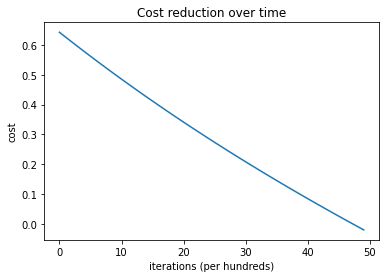

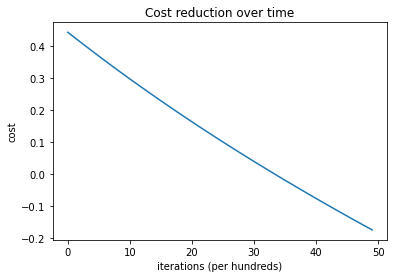

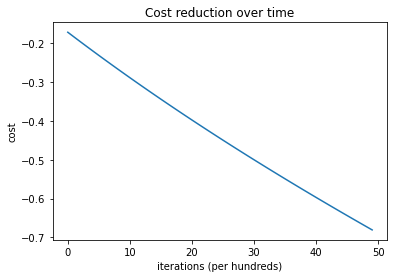

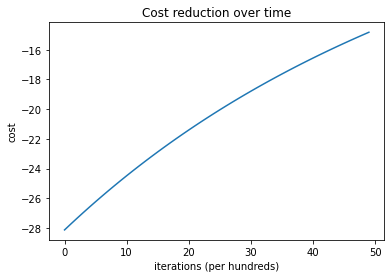

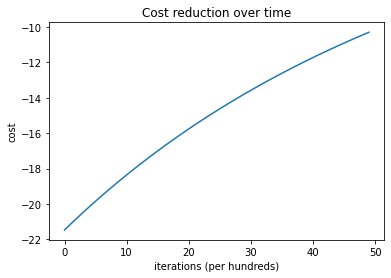

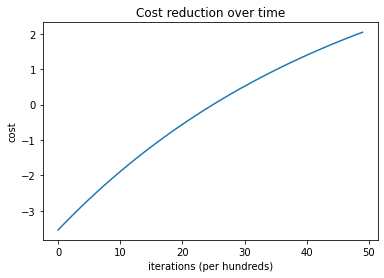

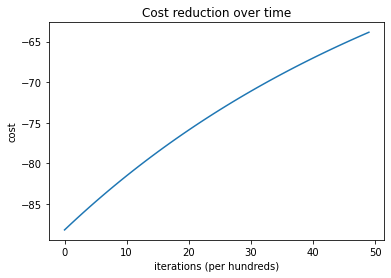

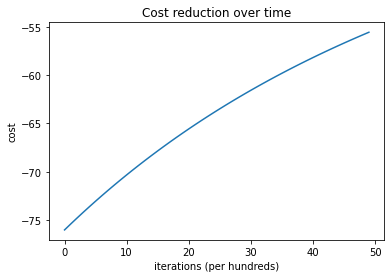

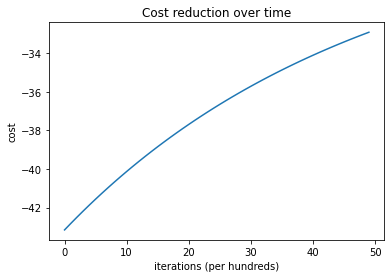

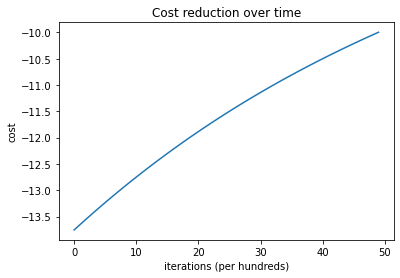

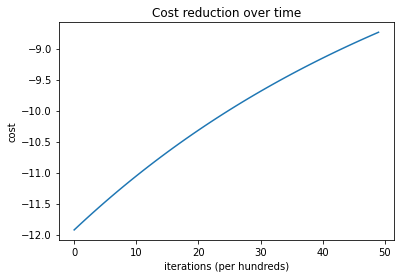

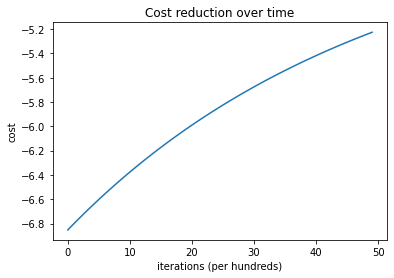

In [13]:
# optimizers
for b in [0.05, 0.25, 0.95]:
    accuracy(sigmoid_activation, b, 0.0001, 5000)
for b in [0.05, 0.25, 0.95]:
    accuracy(sigmoid_activation, b, 0.0001, 5000, opt=simple)
for b in [0.05, 0.25, 0.95]:
    accuracy(sigmoid_activation, b, 0.0001, 5000, opt=nesterov)
for b in [0.05, 0.25, 0.95]:
    accuracy(sigmoid_activation, b, 0.0001, 5000, opt=rms_prop)

In [11]:
def show():
    np.random.seed(10)
    num_observations = 10000
    x1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], num_observations)
    x2 = np.random.multivariate_normal([1, 4], [[1, 0.5], [0.5, 1]], num_observations)

    simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
    simulated_labels = np.hstack((np.zeros(num_observations), np.ones(num_observations)))

    plt.figure(figsize=(10, 8))
    plt.scatter(simulated_separableish_features[:, 0],   simulated_separableish_features[:, 1], c=simulated_labels,    alpha=0.3,)

    plt.show()

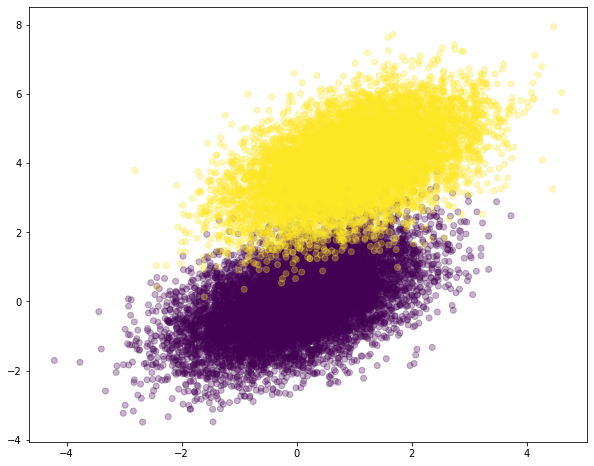

In [102]:
show()